# Feature engineering

This notebook takes care of the feature engineering part, in particular we're gonna add 3 new features to the dataset.

In [330]:
import pandas as pd
from os import path

RACES_PATH=path.join("..","dataset","races_cleaned.csv")
races_df=pd.read_csv(RACES_PATH)

CYCLISTS_PATH=path.join("..","dataset","cyclists_cleaned.csv")
cyclist_df=pd.read_csv(CYCLISTS_PATH)

## before starting the analysis

So as we observed from the original dataset we can see that climb_total is heavilty related to the values of the profile, so we can try to use that and gain some insight in the meaning of the five categories in the profile and ee how they map to the ones specified in the dataset description.

first of all we used the sturge rule to determine the number of bins necessary, after determining the number of bins we plot them in a grouped bar  plot as above, as  we can see some intersting information is already visible affter apply the log scale to make easy visualizing differences for small values since we are on different scales.

On the right side we observe that values 1, 2 and 3 are nevver present in the last 3 bins with the highest climb totals, assuming high climb totals correspond to mountains or high mountains we can say that 1,2,3 can be restricted to 'flat' and 'hilly' where climb totals tend to be low.

Plotting in original scale we see that category 3 is heavily present in the first bin this suggests it to be the 'flat' category.
From th original scale we also see that category 1 is very present in the first lower half of the bins and disappears when climb total goes up it seems to be reasonable that it is 'hilly' category(basically slightly higher than the others but doesn't make it to higher climb totals where mountain and high mountains are located).

2 displays a behavior similar to 3 and 1 it is not clear if it can ba attribute to flat or hilly given the fact that it manages to reach ighe climb totals bins like 3 it seems resonable to attribute it to hilly.

finally 4 can be attributed to 'montainous' and 5 to 'high mountains' this is because 4 is always present but way less than 5 at higher climb total bins.

This is the final mapping:
- 1,2 -> 'hilly'
- 3   -> 'flat'
- 4   -> 'montainous'
- 5   -> 'high mountains'

Such mapping is gonna be used to attribute a difficulty to each category in later parts of the analysis.

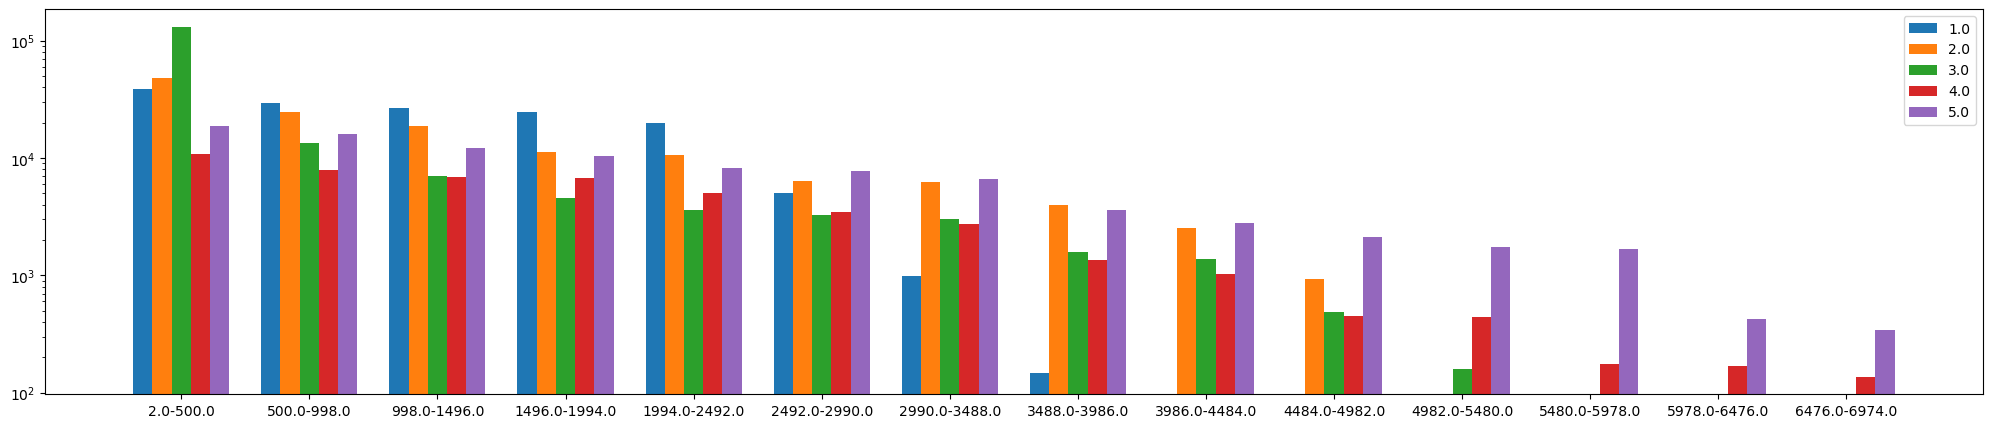

In [331]:
import matplotlib.pyplot as plt
import itertools as it
#races_df.groupby('profile')['climb_total'].plot()
def plot_profile_distributons(races_df,log_flag=False):
    val=races_df['climb_total']
    n_bins=int(np.ceil(np.log( len(races_df))+1))
    bins=np.linspace(races_df['climb_total'].min(),races_df['climb_total'].max(),num=n_bins)
    bins_labels=list(map(lambda x: f"{x[0]}-{x[1]}",it.pairwise(bins)))

    width=0.15
    plt.figure(figsize=(25,5))

    x_axis=np.array(range(len(bins_labels)))

    for i,(k,g) in enumerate(races_df.groupby('profile')):
        binned=pd.cut(g['climb_total'],bins=bins,labels=bins_labels)
        plt.bar(x_axis+(i-2)*width,binned.value_counts().values,width=width,label=k)
    plt.xticks(x_axis,bins_labels)
    if log_flag:plt.yscale('log')
    plt.legend()
    #plt.show()
plot_profile_distributons(races_df,True)

without log scale


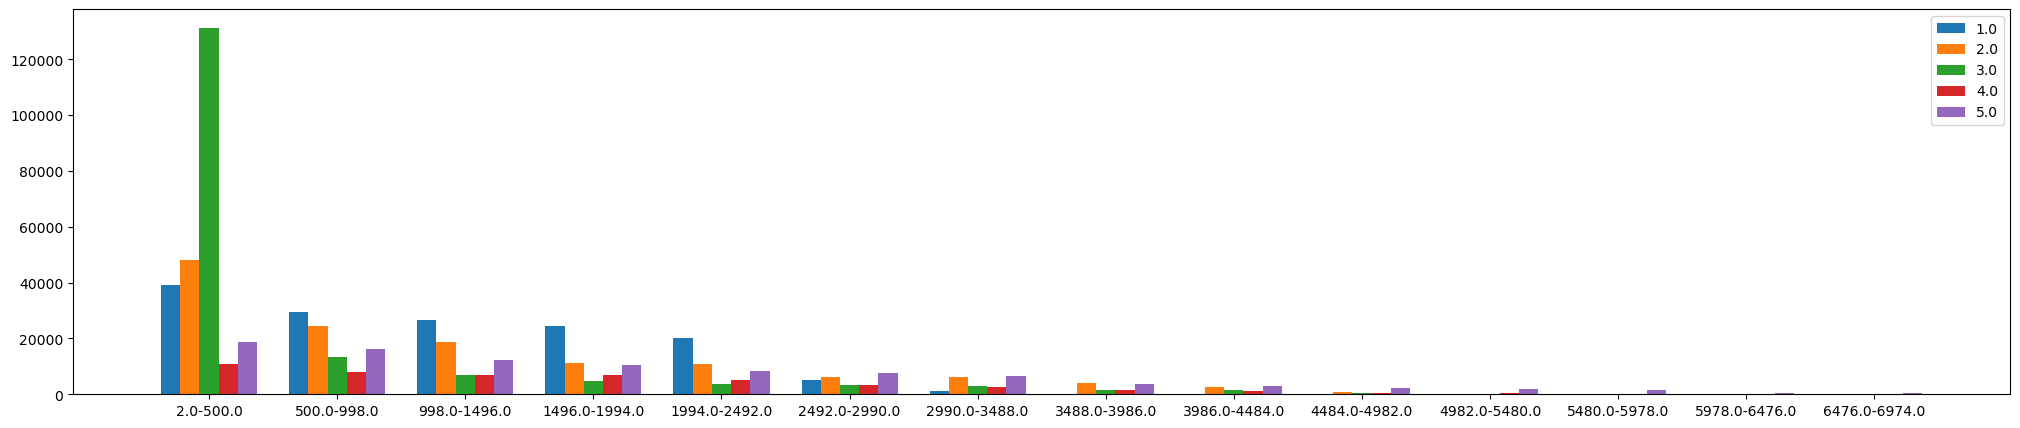

In [332]:
print("without log scale")
plot_profile_distributons(races_df)



Before analyzing the features we edveloped it is important to note that our main entities to be analyzed are races and cyclists, some features depends only on the cyclists, others only on the race and some on both to highlight such relationship we specify this in function like manner `features(entity)`.

Also during the analysis much more features emerged to be necessary in order to determine the original 3 ones we developed.

## engineered features

The features we came up are:
- climbing_efficiency: we want to get a ratio between the climb total and the length, this  can help us understand better the performances for cyclists on different kind of slopeness on average for the race.
$$
climbing\_ efficiency(race)= \frac{climb\_ total(race)(m)}{length(race)(KM)\times 1000}
$$
Note: length is multiplied by 1000 to get the same unit as the length
- competitive\_age: we calculate the difference the age a cyclist has at the time of the race, this is useful because we might track the performances  of a single cyclist in multiple races across time and determine,if possible, if there are ages that are more performant that others or any kind of pattern across ages.
$$
competitive\_age(cyclist,race)=current\_ race \_ date(race) - cyclist\_ age(cyclist)
$$

- difficulty: this one serves to estimate the difficulty an athlete might have when facing certain stages, the important factors are
    - the difficulty of the terrain quantified by the terrain \_ score which is the weight sum of the difficulty of each profile type for a certain race, the elements being weighted are the difficulties attributed to each profile type and the weights are determined for each race using the percentage of time the profile appears.
    - the age of the athlete at the time of the race i.e. the competitive age
    - the BMI of the athlete
    The rationale is that a person that is older, overweight and deals with a difficult race has a lot more difficulty than another that is in shape, younger for the same race.
    
$$
terrain \_ score(race) = \sum_i\frac{( \# \text{of times terrain } i \text{ appears in the race}) }{( \# \text{of stages for the race})}*(\text{terrain $i$ difficulty})
$$
$$
difficulty(cyclist,race)=climbing\_ efficiency(race)*terrain \_ score(race) * BMI(cyclist) * competitive \_ age(cyclist)
$$

- convenience\_score: a ratio between points and difficulty, basically how much we gain from participating on certain races. The points of this feature is to find if there is any cyclist that tries to maximize the points gained while partecipating to the least difficult races or a brave one that goes to partecipate in difficult races to the it's capabilities and so on with any kind of behavioral pattern we can deduct.
$$
convenience\_ score(cyclist,age)=\frac{points(cyclist)}{difficulty(cyclist,age)}
$$

Note: the type of terrain is also important however in the dataset it is very noisy given that only is_tarmac is available and other values are difficult to determine so it is not considered inside the formulas.

In [ ]:
import numpy as np

races_df['climbing_efficiency']=(races_df['climb_total'])/races_df['length']
races_df['date']=pd.to_datetime(races_df['date'])

years_to_sub=races_df.merge(cyclist_df,left_on="cyclist",right_on="_url",how='inner')['birth_year'].astype('int32')
races_df['competitive_age']=races_df['date'].dt.year-years_to_sub

#profile types difficulty for terrain difficulty estimation
terrain_difficulty={
    1:100,
    2:100,
    3:300,
    4:400,
    5:500
}

#extract name, and stage. Year can be deducted from the date feature
url_df=races_df['_url'].str.split('/',expand=True)
url_df.rename(columns={0:'name',1:'year',2:'stage'},inplace=True)
races_df['std_name']=url_df['name']
races_df['stage']=url_df['stage']

#group races by (race_name,year)
stages_grouping=races_df.groupby(['std_name',races_df.date.dt.year])

#calculate components of the difficulty formula coming from the race
profile_difficulty=races_df['profile'].map(terrain_difficulty)
profile_counting=stages_grouping['profile'].transform('size')
profile_freqs=stages_grouping['profile'].value_counts().reset_index(name='prof_freqs')
profile_freqs=races_df.merge(profile_freqs,left_on=['std_name',races_df.date.dt.year],right_on=['std_name','date'],how='inner')['prof_freqs']

# calculate components of the  difficulty formula coming from the cyclist
cyclists_physicals=races_df.merge(cyclist_df,left_on='cyclist',right_on='_url',how='inner')[['weight','height']]
cyclist_df['bmi']=cyclist_df['weight'] / (cyclist_df['height']/100) ** 2
cyclist_bmi=races_df.merge(cyclist_df,left_on=['cyclist'],right_on=['_url'],how='inner')['bmi']

diff_terms_df=pd.DataFrame()

# gather the terms to calculate difficulty
diff_terms_df['norm_bmi']=cyclist_bmi
diff_terms_df['norm_age']=races_df['competitive_age']
diff_terms_df['norm_terrain_diff']=((profile_freqs/profile_counting)*profile_difficulty)+1

#calculate formula,difficulty score and remove useless columns
races_df['difficulty']= diff_terms_df['norm_bmi']*diff_terms_df['norm_age']*diff_terms_df['norm_terrain_diff']
# avoid diving by 0 in convenience score calculation
races_df['difficulty']+=1

races_df['convenience_score']= races_df['points']/races_df['difficulty']
races_df['convenience_score']= (races_df['convenience_score']-races_df['convenience_score'].min())/(races_df['convenience_score'].max()-races_df['convenience_score'].min())
# as per the description of the dataset the hour of start is noisy and irrelevant, therefore it is evicted
races_df['date']=races_df['date'].dt.date
# url and name are to be dropped since we don't need them anymore
races_df=races_df.drop(columns=['_url','name'])

Note: a nice analysis to do could be look for performance at high altitudes (lungs capacity maybe), in 50's and 60's training and eating changed so athlets in more recents races should perform better on high altitudes or we show see a trend for better performances (t.b.d. later how to measure them) as years get close to 2024.